<a href="https://colab.research.google.com/github/jacr2006/android-tflitemodel-drowsiness-detection/blob/master/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset usado https://ibug.doc.ic.ac.uk/resources/300-W/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install xmltodict

In [0]:
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

###**Datos**
Procesamiento de los datos: escalado y normalizacion

In [0]:
PATH_DRIVE = '/content/drive/My Drive/Proyectos Nuevos/ML/multiclass_landmark_keras_cnn/'
PATH_DATASET = 'ibug_300W_large_face_landmark_dataset/'
pathXml = PATH_DRIVE + PATH_DATASET + 'labels_ibug_300W_train.xml'# archivo con los datos de entrenamiento
with open(pathXml, 'r') as file:
  dict = xmltodict.parse(file.read())# lectura del archivo xml y conversion a diccionario

In [5]:
IMG_NUM=2689
pathImg = dict['dataset']['images']['image'][IMG_NUM]['@file']# ruta de la imagen

x=[]
y=[]
for i in range(68):# marcas faciales de la imagen
  x.append( int(dict['dataset']['images']['image'][IMG_NUM]['box']['part'][i]['@x']) )
  y.append( int(dict['dataset']['images']['image'][IMG_NUM]['box']['part'][i]['@y']) )

left = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@left'] )# rectangulo sobre el rostro, asi que no es necesario usar ningun algoritmo de deteccion de rostros
top = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@top'] )
width = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@width'] )
height = int( dict['dataset']['images']['image'][IMG_NUM]['box']['@height'] )

print(pathImg)
print(left)
print(top)
print(width)
print(height)


helen/trainset/2869939639_3.jpg
378
378
447
447


Escalado de una imagen

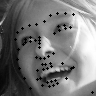

In [6]:
IMG_WIDTH = 96# tamaño de a imagen de entrada de la CNN
IMG_HEIGHT = 96
IMG_CHANNEL = 1# imagen en escala de grises

img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )
cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la region de interes (ROI)

xcrop=[]
ycrop=[]
for i in range(68):# escalado de las marcas faciales a la ROI
  xcrop.append( x[i]-left )
  ycrop.append( y[i]-top )

mcrop=list(zip(xcrop,ycrop))

rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen usando opencv
grayImg = cv2.cvtColor(rezImg, cv2.COLOR_BGR2GRAY)# conversion de RGB a escala de grises con opencv.

xrez=[]
yrez=[]
for i in range( 68 ):# escalado de las marcas faciales en la misma proporcion de la imagen
  xrez.append( int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )
  yrez.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )
  #print(str(xrez[i])+'-'+str(yrez[i]) )

marks=zip(xrez,yrez)

for (i, j) in marks:
  cv2.circle(grayImg, (i,j), 1, (0, 0, 255), -1)

cv2_imshow(grayImg)# despliegue de la imagen escalada y en escala de grises
#print(grayImg.shape)



Escalado del dataset completo

In [9]:
LEN=0
for i in dict['dataset']['images']['image']:
  LEN=LEN+1

dataset_array = np.zeros(shape=(LEN, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
pts_array = np.zeros(shape=(LEN, 68, 2))
idx = 0
  
for i in dict['dataset']['images']['image']:# procesamiento de todo el dataset
  pathImg = i['@file']# ruta de la imagen

  left = int(i['box']['@left'])# coordenadas del ROI
  top = int(i['box']['@top'])
  width = int(i['box']['@width'])
  height = int(i['box']['@height'])
  if ( width==0 or height==0 ) :
    continue

  xcrop=[]
  ycrop=[]
  for k in i['box']['part']:# lectura de las marcas faciales
    xcrop.append( int(k['@x'])-left )
    ycrop.append( int(k['@y'])-top )
  
  img=cv2.imread( PATH_DRIVE + PATH_DATASET + pathImg )# lectura de la imagen en tamaño real
  if ( img.shape[0]==0 or img.shape[1]==0 ) :
    continue
  cropImg = img[top:top+height, left:left+width]# recorte de la imagen al tamaño de la ROI
  print( cropImg.shape)
  if ( cropImg.shape[0]==0 or cropImg.shape[1]==0 ) :
    continue
  rezImg = cv2.resize( cropImg, ( IMG_WIDTH, IMG_HEIGHT ) )# escalado de la imagen
  grayImg = cv2.cvtColor(rezImg, cv2.COLOR_BGR2GRAY)# conversion de RGB a escala de grises
  rshImg = grayImg.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)  
  
  dataset_array[idx, :, :, :] = rshImg

  xrez=[]
  yrez=[]
  for i in range( 68 ):# escalado de las marcas faciales en la misma proporcion de la imagen
    xrez.append( int(xcrop[i]*IMG_WIDTH/cropImg.shape[0]) )
    yrez.append( int(ycrop[i]*IMG_HEIGHT/cropImg.shape[1]) )
  points=zip(xrez,yrez)  

  pts_array[idx, :, :] = list(points)
  #print(pts_array[idx, :, :])


np.savez_compressed(PATH_DRIVE + "img_dataset.npz", dataset_array)
np.savez_compressed(PATH_DRIVE + "pts_dataset.npz", pts_array)

(140, 138, 3)
(447, 447, 3)
(447, 446, 3)
(259, 259, 3)
(1111, 1110, 3)
(643, 642, 3)
(372, 372, 3)
(643, 643, 3)
(373, 373, 3)
(311, 311, 3)
(328, 317, 3)
(1110, 1110, 3)
(150, 150, 3)
(310, 311, 3)
(125, 126, 3)
(536, 536, 3)
(536, 536, 3)
(772, 771, 3)
(115, 118, 3)
(125, 125, 3)
(180, 180, 3)
(373, 373, 3)
(311, 311, 3)
(150, 151, 3)
(151, 150, 3)
(310, 310, 3)
(372, 372, 3)
(311, 311, 3)
(180, 180, 3)
(125, 126, 3)
(216, 216, 3)
(125, 126, 3)
(536, 536, 3)
(259, 259, 3)
(150, 151, 3)
(1362, 1382, 3)
(105, 105, 3)
(125, 125, 3)
(373, 373, 3)
(771, 771, 3)
(1110, 1110, 3)
(447, 447, 3)
(373, 373, 3)
(447, 447, 3)
(180, 180, 3)
(126, 125, 3)
(373, 372, 3)
(536, 536, 3)
(122, 119, 3)
(34, 1110, 3)
(771, 771, 3)
(231, 245, 3)
(643, 643, 3)
(446, 447, 3)
(447, 447, 3)
(925, 925, 3)
(0, 373, 3)
(373, 372, 3)
(771, 771, 3)
(216, 216, 3)
(151, 150, 3)
(1110, 1110, 3)
(372, 373, 3)
(373, 372, 3)
(447, 447, 3)
(1918, 1918, 3)
(486, 497, 3)
(771, 771, 3)
(771, 771, 3)
(311, 310, 3)
(926, 925,